# Ensuring Fairness in Classification Tasks

This tutorial will focus on a real-world learning-with-constraint application.

We will use the Moving Targets' APIs to train a neural classifier while imposing a fairness constraint on the whole population, namely the [**Disparate Impact Discrimination Index** ($\mbox{DIDI}$)](https://arxiv.org/abs/1903.10598).

> NOTE: since we will leverage on the [Gurobi](https://www.gurobi.com/) solver to deal with the master problem, you will need to install it separately. A free academic license for the solver can be obtained [here](https://www.gurobi.com/academia/academic-program-and-licenses/). Otherwise, you may change the line of code involving the backend object and use one among the other supported backends.

In [1]:
import numpy as np
import seaborn as sns
import tensorflow as tf

np.random.seed(0)
tf.random.set_seed(0)
sns.set_style('whitegrid')
sns.set_context('notebook')

## The Adult Dataset

This time, we will benchmark our approach on the **Adult** dataset, whose original version can be found on the [UCI Repository](https://archive.ics.uci.edu/ml/datasets/Adult) but, as well as in the previous tutorial, we will use a preprocessed version that can be found in the official Moving Targets' [github repository](https://github.com/moving-targets/moving-targets).

The task consists in predicting the **income** class (*0* = income $\geq 50k$, *1* otherwise) based on the personal attributes of an individual. In particular, we will focus on learning the best classifier while imposing a fairness constraint on the (one-hot encoded) protected feature **race**, which indicates five different protected ethnicity groups: *American-Indian/Eskimo*, *Asian-Pacific Islander*, *Black*, *White*, and *Other*.

In [2]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/moving-targets/moving-targets/main/res/adult.csv')
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,relationship_Unmarried,relationship_Wife,sex_Female,sex_Male,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,income
count,30162.000000,3.016200e+04,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000,...,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000,30162.00000,30162.000000
mean,38.437902,1.897938e+05,10.121312,1092.007858,88.372489,40.931238,0.031265,0.068530,0.738877,0.035608,...,0.106492,0.046615,0.324315,0.675685,0.009482,0.029673,0.093396,0.007659,0.85979,0.248922
std,13.134665,1.056530e+05,2.549995,7406.346497,404.298370,11.979984,0.174035,0.252657,0.439254,0.185313,...,0.308471,0.210816,0.468126,0.468126,0.096915,0.169687,0.290991,0.087179,0.34721,0.432396
min,17.000000,1.376900e+04,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,28.000000,1.176272e+05,9.000000,0.000000,0.000000,40.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000
50%,37.000000,1.784250e+05,10.000000,0.000000,0.000000,40.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000
75%,47.000000,2.376285e+05,13.000000,0.000000,0.000000,45.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


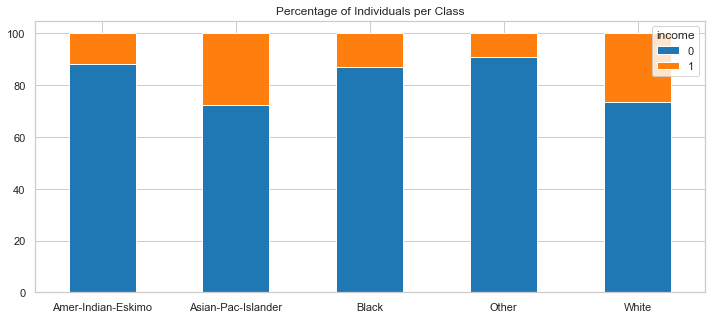

In [3]:
x, y = df.drop(columns='income'), df['income'].astype('category').cat.codes

data = x[[c for c in df.columns if c.startswith('race_')]].idxmax(axis=1).map(lambda c: c[5:])
data = pd.concat((data, y), axis=1).rename(columns={0: 'race', 1: 'income'})
data = data.groupby('race')['income'].value_counts(normalize=True).mul(100).unstack()
fig = data.plot(kind='bar', stacked=True, rot=0, figsize=(12, 5))
fig.set(xlabel='', ylabel='', title='Percentage of Individuals per Class');

The above barplot shows that while the *Asian-Pacific Islander* and *White* groups are over-represented in the positive class (*0*), the three remaining groups are under-represented. Since these classifiers are usually deployed to assist human in decision-marking processes in the financial and insurance fields, the over- and under-representation of some protected groups is likely to lead to discriminatory practices towards their members.

Similarly to the previous tutorial, we will rely on the **Disparate Impact Discrimination Index**, a metric used to quantify the level of (statistical) discrimination which has been introduced [here](https://arxiv.org/abs/1903.10598). This time, we will use its definition for Classification Tasks ($\mbox{DIDI}_c$), namely:

$$
\mbox{DIDI}_c = \sum_{p \in P} \sum_{c \in C} \mid \bar{y^c} - \bar{y_p^c} \mid
$$

where $D$ is the dataset of the entire population and:
* $P$ is the domain of the protected feature and $p$ represents each protected group (e.g., $P = \{p_0=\mbox{black}, p_1=\mbox{hispanic}, p_2=\mbox{asian}, ...\}$)
* $C$ is the domain of the output classes and $c$ represents each output class (e.g., $C = \{c_0=\mbox{accepted}, c_1=\mbox{rejected}, ...\}$)
* $\bar{y^c}$ is the average number of samples with class $c$ respectively to the whole population, i.e., $\bar{y^c} = \frac{\mid D^c \mid}{\mid D \mid}$
* $\bar{y_p^c}$ is the average number of samples with class $c$ and protected feature $p$ respectively to the whole protected population, i.e., $\bar{y_p^c} = \frac{\mid D_p^c \mid}{\mid D_p \mid}$

Intuitively, the *DIDI* measures the sum of the deviations from the overall percentage number of samples targeted as $c$ respectively to the percentage number of samples targeted as $c$ within each protected group, for all the possible targets $c \in C$. Thus, as it approaches a zero value, it means that we are reducing the level of discrimination. Let us see which is the violation level on our dataset using the `DIDI` class which can be found inside the Moving Targets' `metric` package. Notice that in case of one-hot encoded protected groups, it is enough to feed the object with a common prefix (i.e., **race**), and it will automatically compute the indicator matrix based on that:

In [4]:
from moving_targets.metrics import DIDI

didi = DIDI(protected='race', classification=True, percentage=False)
print(f'DIDI: {didi(x=x, y=None, p=y)}')

DIDI: 0.9000396751247404


A pitfall of the *DIDI* is that it is an absolute metric, therefore we have no ways to know whether this is a large amount of discrimination or not. Nonetheless, we can compare different *DIDI* values to understand which of the possible target vectors is less discriminative, or even the level of discrimination of a target vector $y'$ with respect to a target vector $y$ by computing their ratio.

> This is exactly what the `percentage` parameter does: it compares the *DIDI* computed on the predictions $p$ with the *DIDI* computed on the original targets $y$ and yields their ratio. Indeed, here we passed no original targets `y` because we wanted the absolute *DIDI* value, to get the relative value we should have done:
> ```python
> didi = DIDI(protected='race', classification=True, percentage=True)
> didi(x=x, y=y, p=y)
> ```
> which in this case would yield $1.0$ because the two target vectors are the same.

Now, say that we measured a certain $\mbox{DIDI}(y)$ on our original targets. Forcing this value to be exactly zero may lead to excessively poor performances, thus we can formulate our constraint as *20% of the initial discrimination*, or rather:
$$
\mbox{DIDI}(p) \leq 0.2 * \mbox{DIDI}(y)
$$

## Moving Targets

Let us now split the data points into a train and test set in order to compute our reference *DIDI*, then prepare our custom `Master` class.

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=True)
didi_train = didi(x=x_train, y=None, p=y_train)
didi_train

0.8856401259221229

In [6]:
from moving_targets.masters import ClassificationMaster

class FairClassification(ClassificationMaster):
    def __init__(self, protected, didi, backend='gurobi', loss='hd', alpha='harmonic', stats=False):
        super().__init__(backend=backend, loss=loss, alpha=alpha, stats=stats, types='discrete', labelling=False)
        self.protected = protected
        self.didi = didi

    def build(self, x, y, p):
        # 1. RETRIEVE THE VARIABLES
        z = super(FairClassification, self).build(x, y, p)
        # additionally, we transform 1d variables (outputs of binary tasks) into a bi-dimensional matrix for compatibility
        z_bi = np.transpose([1 - z, z]) if z.ndim == 1 else z

        # 2. ADD THE CONSTRAINTS
        #   > compute the indicator matrix
        indicator_matrix = DIDI.get_indicator_matrix(x=x, protected=self.protected)
        #   > retrieve the number of protected groups and output classes, respectively
        groups, classes = len(indicator_matrix), len(np.unique(y))
        #   > add a continuous variable for each pair of protected group and output class
        deviations = self.backend.add_continuous_variables(groups, classes, lb=0.0, name='deviations')
        #   > compute the percentage number of samples having a certain output class for the whole dataset
        total_avg = [self.backend.mean(z_bi[:, c]) for c in range(classes)]
        for g, protected_group in enumerate(indicator_matrix):
            #   > retrieve the subset of the variables having <label> as protected feature (i.e., the protected group)
            protected_vars = z_bi[protected_group]
            if len(protected_vars) == 0:
                continue
            #   > compute the percentage number of samples having a certain output class for the protected group
            protected_avg = [self.backend.mean(protected_vars[:, c]) for c in range(classes)]
            #   > compute the partial deviation as the absolute value (which is linearized) of the difference between
            #   > the total average samples and the average samples within the protected group
            self.backend.add_constraints([deviations[g, c] >= total_avg[c] - protected_avg[c] for c in range(classes)])
            self.backend.add_constraints([deviations[g, c] >= protected_avg[c] - total_avg[c] for c in range(classes)])
        # > eventually compute the DIDI as the sum of this deviations and constrain it
        didi = self.backend.sum(deviations)
        self.backend.add_constraint(didi <= self.didi)

        # 3. RETURN THE (UNMODIFIED) VARIABLES
        return z

This master is very similar to the one discussed in the previous tutorial, with the sole exception of the necessity to deal with categorical outputs (included the trick to handle binary tasks as if they were multi-class tasks) rather than continuous ones. Therefore, for a more detailed explanation of the code, we redirect to that tutorial.

Now that we have formulated the master problem, we can build and fit the `MACS` object, with the usual custom callback to the `fit` method to visually address the level of discrimination during the iterations. However, instead of a simple *scikit-learn*-based logistic regression, we may find it useful to train a neural model due to the inner complexity of this predictive problem. Moving Targets' provides some predefined architectures `tensorflow` and `torch`. For the sake of this tutorial, we will rely on a Multilayer Perceptron architecture built upon the former.

> Do not forget that, even though the input data may be in each acceptable format (e.g., lists, numpy, pandas), the Moving Targets' library always expects and returns a numpy array for the output data.

Finally, since this dataset is bigger than the previous ones, we rely on the `verbose` parameter of the `MACS` object to get check for the progress of the training, as well as creating a custom instance of the `GurobiBackend` class to fix a time limit for the master problem.

Starting the MACS process...
  > it. 00: 23.0191 s
  > it. 01: 42.1254 s
  > it. 02: 53.8674 s
  > it. 03: 69.9787 s
  > it. 04: 71.6825 s
  > it. 05: 61.1946 s
  > it. 06: 56.9003 s
  > it. 07: 70.4109 s
  > it. 08: 69.7178 s
  > it. 09: 70.7259 s
  > it. 10: 70.8994 s


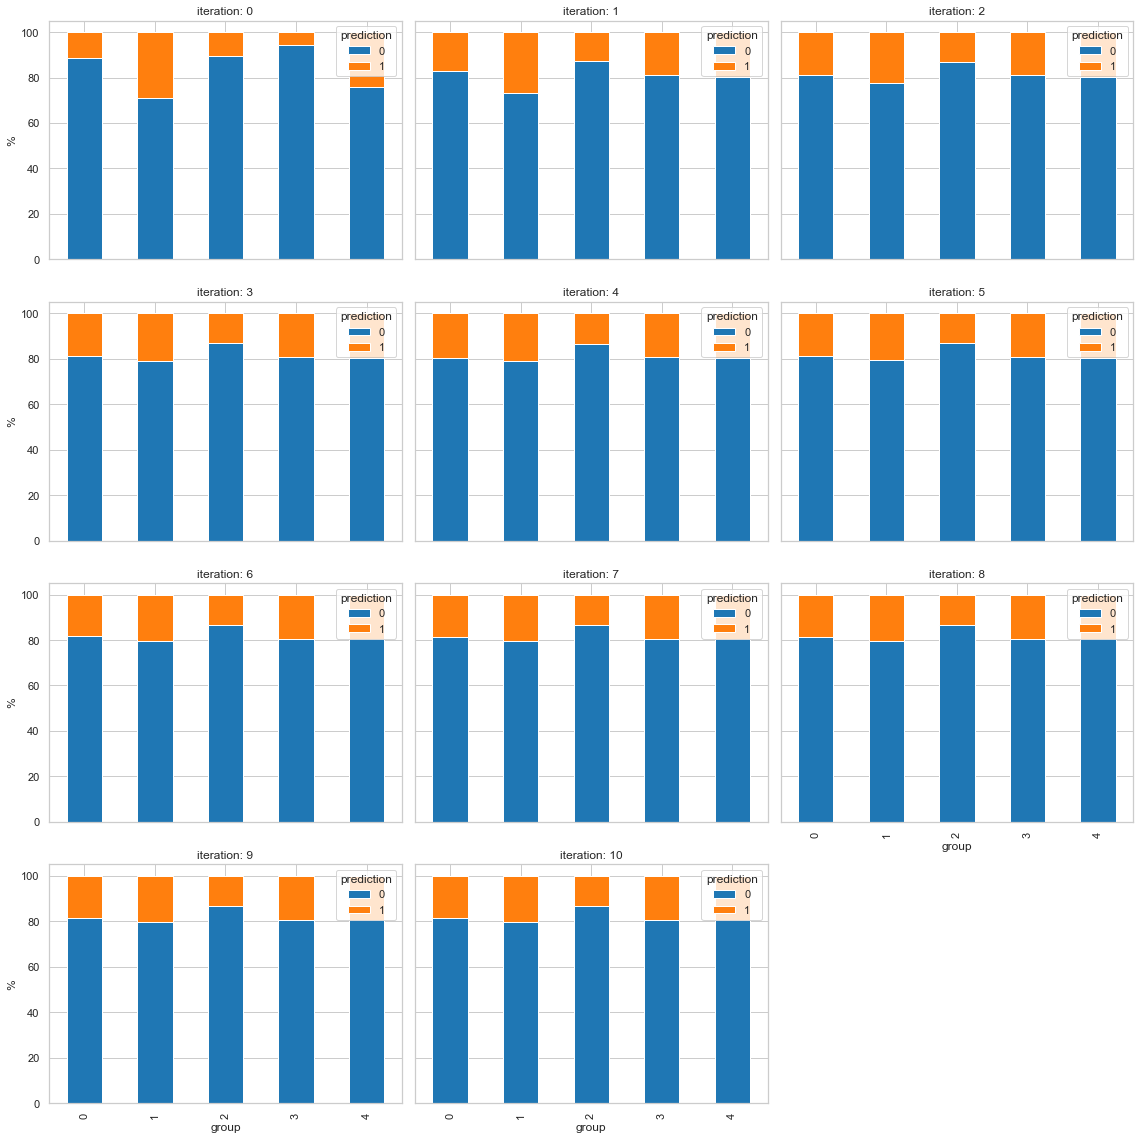

... process ended correctly!


In [7]:
from moving_targets import MACS
from moving_targets.learners import TensorflowMLP
from moving_targets.masters.backends import GurobiBackend
from moving_targets.metrics import CrossEntropy, Accuracy, DIDI
from util.fairness import ClassificationCallback

master=FairClassification(protected='race', didi=0.2 * didi_train, backend=GurobiBackend(time_limit=10))
learner=TensorflowMLP(loss='binary_crossentropy', output_activation='sigmoid', epochs=30, verbose=False, x_scaler='std')
metrics=[CrossEntropy(eps=1e-6), Accuracy(), DIDI(protected='race', classification=True, percentage=True)]
model = MACS(init_step='pretraining', master=master, learner=learner, metrics=metrics)

callbacks = [ClassificationCallback(protected='race', figsize=(16, 16), tight_layout=True)]
val_data = dict(test=(x_test, y_test.values))
history = model.fit(x=x_train, y=y_train.values, iterations=10, val_data=val_data, callbacks=callbacks, verbose=1)

We can now plot the training metrics and statistics via the `History` object and inspect them:

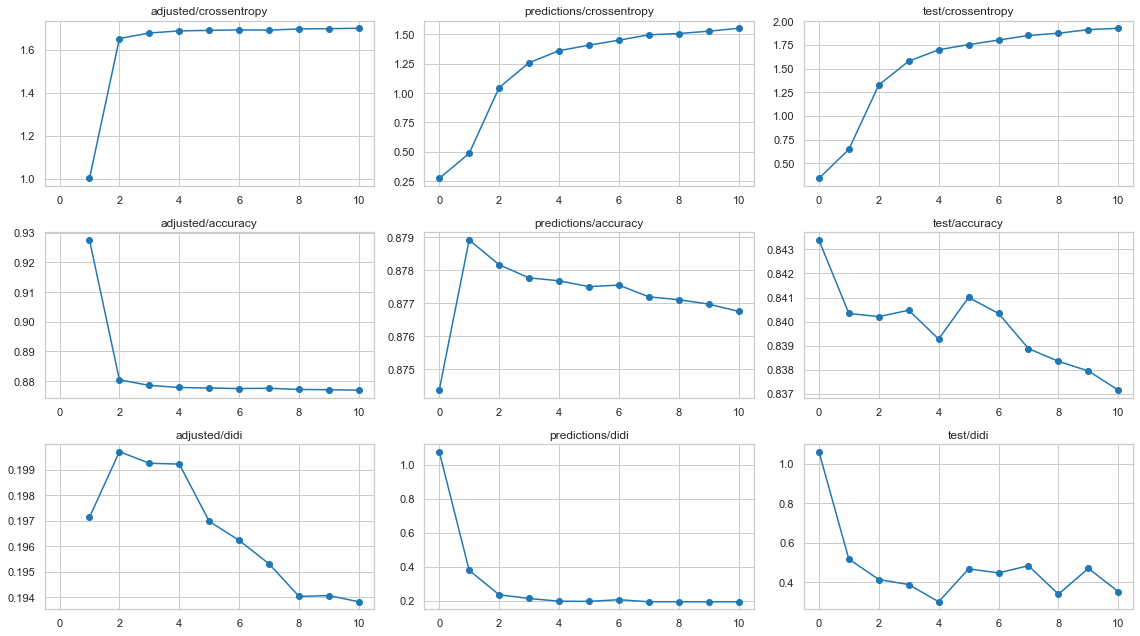

In [8]:
history.plot()

## Conclusions

Again, using Moving Targets we could satisfy our requirement (at least on the training set, but the performance may rise on the test set as well using more computational power) without losing too much in accuracy.

This was the last tutorial. Now, if you have been convinced about the potential of this approach, the last thing to do is to implement your own models and contribute to the development of the library!